In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.train import report
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
import torch.nn.functional as F
import joblib
import os

In [17]:
# Import training and testing sets
X_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_train.csv")
X_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_validate.csv")
X_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_test.csv")
y_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_train.csv").squeeze()
y_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_validate.csv").squeeze()
y_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_test.csv").squeeze()

In [3]:
X_train.shape

(7290722, 78)

# 1. Hyperparameter tuning using training set 5 folds cross validation

## 1.1 Hyperparameter tuning without minibatches

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, layer_sizes):
        super().__init__()
        layers = []
        prev = input_dim
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(negative_slope=0.01)]
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp_cv(config, data=None):
    X, y = data
    X_np = np.array(X)
    y = np.array(y)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    val_losses = []
    val_accuracies = []
    val_f1s = []

    for train_idx, val_idx in kf.split(X_np, y):
        X_train_df, X_val_df = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        #X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # scalling the datasets
        scaler = StandardScaler()

        scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                           "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
        X_train_scaled = X_train_df.copy()
        X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
        X_val_scaled = X_val_df.copy()
        X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

        X_train_scaled = np.array(X_train_scaled)
        X_val_scaled = np.array(X_val_scaled)
        
        # load datatset into GPU
        X_train = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val = torch.tensor(y_val, dtype=torch.long).to(device)

        # Build model from config
        layers = [config["layer_1_size"]]
        if config["n_layers"] >= 2:
            layers.append(config["layer_2_size"])
        if config["n_layers"] == 3:
            layers.append(config["layer_3_size"])
        if config["n_layers"] == 4:
            layers.append(config["layer_4_size"])

        model = MLP(input_dim=X.shape[1], output_dim=len(set(y)), layer_sizes=layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

        best_val_loss = float("inf")
        patience = 5
        patience_counter = 0

        for epoch in range(250):
            model.train()
            optimizer.zero_grad()
            out = model(X_train)
            loss = F.cross_entropy(out, y_train)
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_out = model(X_val)
                val_loss = F.cross_entropy(val_out, y_val).item()
                preds = torch.argmax(val_out, dim=1).cpu().numpy()
                true = y_val.cpu().numpy()
                acc = accuracy_score(true, preds)
                f1 = f1_score(true, preds, average="weighted")
            
            # early stopper if patience reached
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_acc = acc
                best_f1 = f1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Patience reached")
                    break

        val_losses.append(best_val_loss)
        val_accuracies.append(best_acc)
        val_f1s.append(best_f1)

        # Clean the GPU memory between each model
        del model
        torch.cuda.empty_cache()

    # Report mean metrics to Ray Tune

    metric = {
        "val_loss" : np.mean(val_losses),
        "accuracy" : np.mean(val_accuracies),
        "f1_score" : np.mean(val_f1s)
        }

    tune.report(metrics=metric)

## 1.2 Hyperparameter tuning using minibatches

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, layer_sizes):
        super().__init__()
        layers = []
        prev = input_dim
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(negative_slope=0.01)]
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp_cv(config, data=None):
    X, y = data
    X_np = np.array(X)
    y = np.array(y)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    val_losses = []
    val_accuracies = []
    val_f1s = []

    for train_idx, val_idx in kf.split(X_np, y):
        X_train_df, X_val_df = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        #X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # scalling the datasets
        scaler = StandardScaler()

        scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                           "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
        X_train_scaled = X_train_df.copy()
        X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
        X_val_scaled = X_val_df.copy()
        X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

        X_train_scaled = np.array(X_train_scaled)
        X_val_scaled = np.array(X_val_scaled)
        
        # load datatset into GPU
        X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        X_val = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val = torch.tensor(y_val, dtype=torch.long).to(device)

        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=config["batch_size"],
                                                   shuffle=True)

        # Build model from config
        layers = [config["layer_1_size"]]
        if config["n_layers"] >= 2:
            layers.append(config["layer_2_size"])
        if config["n_layers"] == 3:
            layers.append(config["layer_3_size"])
        if config["n_layers"] == 4:
            layers.append(config["layer_4_size"])

        model = MLP(input_dim=X.shape[1], output_dim=len(set(y)), layer_sizes=layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

        best_val_loss = float("inf")
        patience = 5
        patience_counter = 0

        for epoch in range(250):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = F.cross_entropy(out, yb)
                loss.backward()
                optimizer.step()


            # Validation
            model.eval()
            with torch.no_grad():
                val_out = model(X_val)
                val_loss = F.cross_entropy(val_out, y_val).item()
                preds = torch.argmax(val_out, dim=1).cpu().numpy()
                true = y_val.cpu().numpy()
                acc = accuracy_score(true, preds)
                f1 = f1_score(true, preds, average="weighted")
            
            print(f"Epoch number {epoch} completed")

            # early stopper if patience reached
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_acc = acc
                best_f1 = f1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Patience reached")
                    break

        val_losses.append(best_val_loss)
        val_accuracies.append(best_acc)
        val_f1s.append(best_f1)

        # Clean the GPU memory between each model
        del model
        torch.cuda.empty_cache()

    # Report mean metrics to Ray Tune

    metric = {
        "val_loss" : np.mean(val_losses),
        "accuracy" : np.mean(val_accuracies),
        "f1_score" : np.mean(val_f1s)
        }

    tune.report(metrics=metric)

In [5]:
search_space = {
    "n_layers": tune.choice([3, 4]),
    "layer_1_size": tune.choice([512]),
    "layer_2_size": tune.choice([256]),
    "layer_3_size": tune.choice([128]),
    "layer_4_size": tune.choice([64]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([32, 64, 128])
}

tune.run(
    tune.with_parameters(train_mlp_cv, data=(X_train, y_train)),
    config=search_space,
    num_samples=5,
    scheduler=ASHAScheduler(metric="val_loss", mode="min"),
    search_alg=OptunaSearch(metric="val_loss", mode="min"),
    resources_per_trial={"cpu": 4, "gpu": 1},
    max_concurrent_trials=1,
    storage_path="/home/s2106664/msc_project/model_training/ray_tune_results"
)

2025-07-06 12:05:00,607	INFO worker.py:1917 -- Started a local Ray instance.
2025-07-06 12:05:01,446	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-07-06 12:05:01,448	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2025-07-06 12:05:01,453] A new study created in memory with name: optuna


(train_mlp_cv pid=3700136) Using device: cuda
(train_mlp_cv pid=3700136) Patience reached
(train_mlp_cv pid=3700136) Patience reached
(train_mlp_cv pid=3700136) Patience reached
(train_mlp_cv pid=3700136) Patience reached


Trial name,accuracy,f1_score,val_loss
train_mlp_cv_3c6c71d2,0.662099,0.659087,0.55761
train_mlp_cv_983d4b19,0.565405,0.50712,0.719565
train_mlp_cv_bbafd359,0.604129,0.602909,0.63014


(train_mlp_cv pid=3700136) Patience reached
(train_mlp_cv pid=3706728) Using device: cuda
(train_mlp_cv pid=3706728) Patience reached
(train_mlp_cv pid=3706728) Patience reached
(train_mlp_cv pid=3706728) Patience reached
(train_mlp_cv pid=3706728) Patience reached
(train_mlp_cv pid=3706728) Patience reached
(train_mlp_cv pid=3708091) Using device: cuda
(train_mlp_cv pid=3708091) Patience reached
(train_mlp_cv pid=3708091) Patience reached
(train_mlp_cv pid=3708091) Patience reached
(train_mlp_cv pid=3708091) Patience reached
(train_mlp_cv pid=3708091) Patience reached
(train_mlp_cv pid=3731094) Using device: cuda


2025-07-06 18:54:50,856	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-07-06 18:54:50,877	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/s2106664/msc_project/model_training/ray_tune_results/train_mlp_cv_2025-07-06_12-05-01' in 0.0200s.
2025-07-06 18:55:00,885	INFO tune.py:1041 -- Total run time: 24599.44 seconds (24589.40 seconds for the tuning loop).
2025-07-06 18:55:00,886	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


Best parameter from ray tune:
- batch size: 128
- learning rate: 0.00012211471427518402
- number of layer: 4
- layer 1 size: 512
- layer 2 size: 512
- layer 3 size: 64
- layer 4 size: 128

# 2. Final model training

## 2.1 Model training using best hyperparameter from raytune

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    

def train_and_save_model(X_train_data, y_train_data, X_validate_data, y_validate_data,
                         batch_size=64, learning_rate=0.00015, save_path="mlp_model.pt"):

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    # Scale features
    scaler = StandardScaler()
    scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                       "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
    
    X_train_scaled = X_train_data.copy()
    X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
    X_val_scaled = X_validate_data.copy()
    X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

    # Save scaler for later use in testing
    joblib.dump(scaler, "scaler.pkl")

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_data.values, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_validate_data.values, dtype=torch.long).to(device)

    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLP(input_dim=X_train_tensor.shape[1], output_dim=len(set(y_train_data))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    patience = 5
    patience_counter = 0

    # save the best model
    best_model = None

    for epoch in range(1, 251):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_out = model(X_val_tensor)
            val_loss = F.cross_entropy(val_out, y_val_tensor).item()
            val_losses.append(val_loss)

            # Save the model checkpoint
            checkpoint_dir = "/home/s2106664/msc_project/model_training/MLP_checkpoints"
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_epoch_{epoch:03d}.pth"))

            if val_loss < best_val_loss:
                print(f"New best model found at epoch {epoch:03d} with val loss {val_loss:.4f}")
                best_val_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

        print(f"Epoch {epoch:03d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")

    # Save model state
    save_path = "/home/s2106664/msc_project/model_training/best_mlp_model.pth"
    torch.save(best_model, save_path)

    print(f"Model saved to {save_path}")

    return train_losses, val_losses

## 2.2 Model evaluation (Sigmoid)

In [18]:
# Load scaler
scaler = joblib.load("scaler.pkl")

# Set device
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"
    print(f"Using device: {device}")

# Features to scale (same as training)
scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                   "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]

X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Convert to tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32).to(device)


class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)


# Initialize and load the saved model
input_dim = X_test_tensor.shape[1]
model = MLP(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("/home/s2106664/msc_project/model_training/MLP_sigmoid/best_mlp_sigmoid_model.pth"))
model.eval()


# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.sigmoid(outputs)              # Convert logits to probabilities
    predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5

predicted = predicted.cpu().numpy()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')  # or 'macro', 'micro' based on your need

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Test Accuracy: 0.6780
Test F1 Score: 0.6765


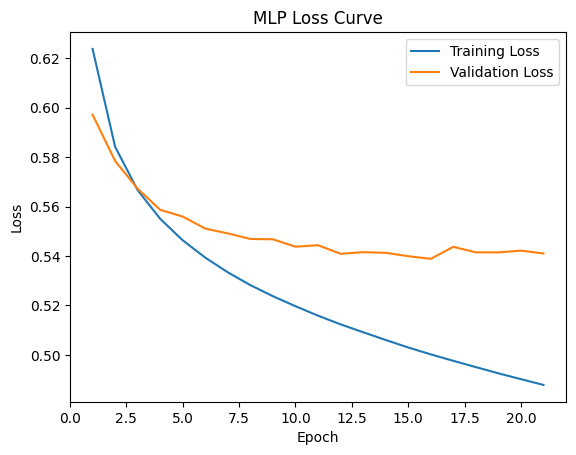

In [19]:
loss_df = pd.read_csv("/home/s2106664/msc_project/model_training/MLP_sigmoid/mlp_train_validation_losses_sigmoid.csv")

plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Training Loss')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Loss Curve')
plt.legend()
plt.savefig("MLP_loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()

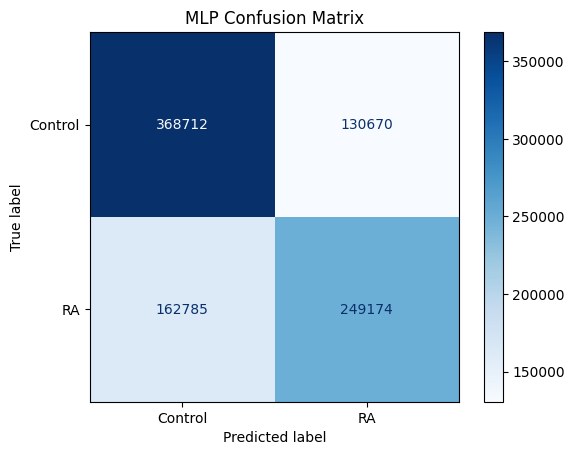

In [15]:
# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.sigmoid(outputs) 
    predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5

predicted = predicted.cpu().numpy()

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "RA"])
disp.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.savefig("MLP_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

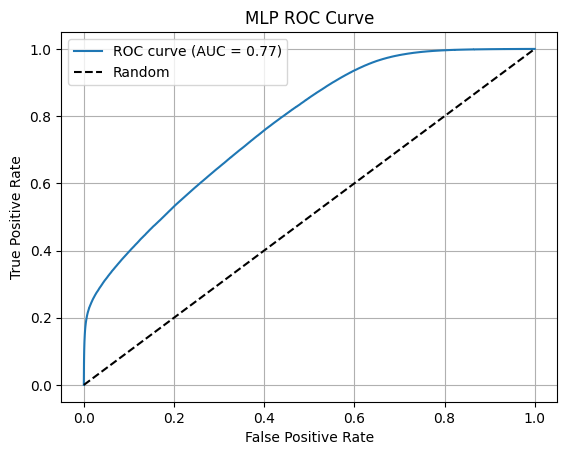

Probabilities (first 10): [4.8466316e-01 5.3268248e-01 7.0365047e-04 5.4254806e-01 4.1096836e-01
 3.1645305e-02 3.9626387e-01 5.7556391e-01 8.0699933e-01 3.5264927e-01]
True labels (first 10): [0 0 0 0 0 0 1 1 1 1]


In [8]:
with torch.no_grad():
    output = model(X_test_tensor)  # shape: (N, 1)
    probs = torch.sigmoid(output).cpu().numpy().squeeze()  # shape: (N,)
    y_true = y_test.values

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("MLP_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some predictions and labels
print("Probabilities (first 10):", probs[:10])
print("True labels (first 10):", y_true[:10])